# The aim of this project is to make stock price prediction using stock price data from yahoo finance

In [9]:
import yfinance as yf

# Download Apple stock data (2010-2023)
data = yf.download('AAPL', start='2011-01-01', end='2024-12-31')
data = data[['Close']]  # Focus on closing prices

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [15]:
data.isnull().sum()  # Check for missing values
data.fillna(method='ffill', inplace=True)  # Forward-fill gaps
#ignore warnnings
import warnings
warnings.filterwarnings('ignore')


C:\Users\JOSHUA\AppData\Local\Temp\ipykernel_3076\3298289162.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward-fill gaps


In [17]:
#Normalizing the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [19]:
#Split data into input (X) and output (y) sequences.
import numpy as np

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60  # Using 60 days of data to predict the next day
X, y = create_sequences(scaled_data, window_size)

In [21]:
#Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [23]:
#Adding moving averages, RSI, and MACD:
# Calculate 20-day and 50-day moving averages
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Calculate RSI (Relative Strength Index)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))



In [27]:
#including past values a predictors
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)

In [34]:
#model building (LSTM MODEL:TENSORFLOW)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape input for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.0077
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 6.0639e-04
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 6.3401e-04
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 5.7476e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 5.1805e-04
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 4.5520e-04
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 4.3827e-04
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 4.9746e-04
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 4.3259e-04
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 3.7568e-04
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 5.3409e-04
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 3.6402e-04
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 3.9244e-04
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 3.8768e-04
Epoch 15/50
87/8

In [38]:
#ARIMA model(baseline)
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(p, d, q)
arima_model = ARIMA(data['Close'], order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(start=len(X_train), end=len(X_train)+len(X_test)-1)

C:\Users\JOSHUA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\JOSHUA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\JOSHUA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
#Model evaliuation (predicitons and inverse scaling)
# LSTM predictions
lstm_pred = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# ARIMA predictions (already in original scale)
arima_pred = arima_pred.values

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [42]:
#Calculating metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM
lstm_mse = mean_squared_error(y_test_actual, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)

# ARIMA
arima_mse = mean_squared_error(y_test_actual, arima_pred)
arima_rmse = np.sqrt(arima_mse)

print(f"LSTM RMSE: {lstm_rmse}")
print(f"ARIMA RMSE: {arima_rmse}")

LSTM RMSE: 8.458373728501488
ARIMA RMSE: 21.54638852829839


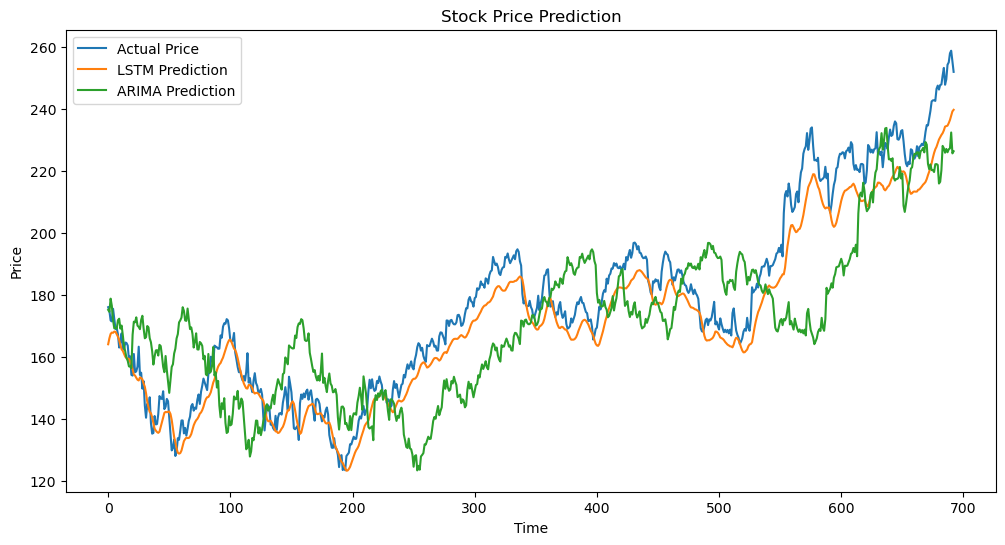

In [44]:
#Visualing Resulta
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(lstm_pred, label='LSTM Prediction')
plt.plot(arima_pred, label='ARIMA Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [46]:
#deployment
# Example using Streamlit
import streamlit as st

st.title('Stock Price Predictor')
ticker = st.text_input('Enter Stock Ticker (e.g., AAPL)', 'AAPL')

if st.button('Predict'):
    data = yf.download(ticker, start='2010-01-01', end='2023-12-31')
    # Preprocess data and generate predictions
    st.line_chart(data['Close'])

2025-02-18 00:47:15.305 
  command:

    streamlit run C:\Users\JOSHUA\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
